# Large-scale object detection!
<img src="https://media.giphy.com/media/HcDTGSmMMfmWtrcHAs/giphy.gif" width="1000" height="600"/>
This notebook attempts to demonstrate how to train and set Up large data sets on NorthernDatas A100 Instances.

## introduction

Training EfficientDet
For our example,we will be implementing the data loader and training loop for training EfficientDet, a Scalable and Efficient Object Detector.

Today, many computer vision projects revolve around identifying specific objects in pictures or videos and then performing certain operations on them, such as classification or segmentation. Typically, a labelled dataset is created by domain experts and then machine learning engineers train or rather retrain an object detection model (applying transfer learning) on this dataset to mimic the experts' knowledge. When your use case primarily requires high speed, such as in the case of video processing, today, one of the YOLO variants are probably the go-to model, but when your use case requires high accuracy with manageable size and speed, EfficientDet should probably your first choice. However, training EfficientDet On a large Variety of objects is a very resource-intensive project. It requires millions of training images To achieve good results. In this notebook, I'll walk you through how to set up such a dataset and the best approach for training Robustly without any Crashes or hiccups on the NorthernData DXG 100.

# step 1. Install dependencies and clone project and add to pyhton path

In [ ]:
!pip3 install pycocotools numpy opencv-python tqdm tensorboard tensorboardX pyyaml webcolors matplotlib pytubeX pytube MoviePy
# !pip3 install torch==1.8.1+cu111 torchvision==0.9.1+cu111 torchaudio==0.8.1 -f https://download.pytorch.org/whl/torch_stable.html


In [ ]:
import os
import sys
if "Pytorch-Large-Dataset-Example" not in os.getcwd():
  !git clone --depth 1 "https://github.com/Northern-Data-AG/Pytorch-Large-Dataset-Example.git"
  os.chdir('Pytorch-Large-Dataset-Example')
  sys.path.append('.')
else:
  !git pull

# step 2. download pre-trained model as we will be using transfer learning to speed up conversions

In [ ]:
! mkdir weights
! wget https://www.dropbox.com/s/uferf32yviczj3p/efficientdet-d3_1_152500.pth?dl=0 -O weights/efficientdet-d3.pth

mkdir: cannot create directory ‘weights’: File exists
--2021-05-12 12:43:29--  https://www.dropbox.com/s/uferf32yviczj3p/efficientdet-d3_1_152500.pth?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.82.18, 2620:100:6032:18::a27d:5212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.82.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/uferf32yviczj3p/efficientdet-d3_1_152500.pth [following]
--2021-05-12 12:43:29--  https://www.dropbox.com/s/raw/uferf32yviczj3p/efficientdet-d3_1_152500.pth
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc48ae5a9ce9dbcf283f2a12bf28.dl.dropboxusercontent.com/cd/0/inline/BOU2XRLCpQ4zICNfweK4hSdOrz96zbMvVTZHa5YldsR4_LP1rUiDcV2cEY4HUi9l25ogNtBrEr33meuNPzSdq5VM-yqW_qdCQjSm-9N2jXjPi7IFVOu0rsTnoYuF-rMsuNtYCS7oLkvMdCuipZt90S76/file# [following]
--2021-05-12 12:43:30--  https://uc48ae5a9ce9dbcf283f2a12bf28.dl.dropboxusercont

In [ ]:
!mkdir dataset
!wget https://storage.googleapis.com/nds_hpc_examples/object365tiy.tar.gz -O dataset/object365tiy.tar.gz
!cd dataset && tar -xf object365tiy.tar.gz

mkdir: cannot create directory ‘dataset’: File exists
--2021-05-12 12:43:35--  https://storage.googleapis.com/nds_hpc_examples/object365tiy.tar.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.188.128, 64.233.189.128, 108.177.125.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.188.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1642755707 (1.5G) [application/gzip]
Saving to: ‘dataset/object365tiy.tar.gz’

dataset/object365ti 100%[===================>]   1.53G  52.2MB/s    in 28s     

2021-05-12 12:44:03 (56.4 MB/s) - ‘dataset/object365tiy.tar.gz’ saved [1642755707/1642755707]



# Step 3. Write a DataSet class to handle are dataset.

As we wanted to train a custom object detector, a common data set format for this is the COCO dataset format. This is essentially a large JSON.

We want to extract the two exciting things from our labels file: the images, the corresponding annotations.

The "images" section contains the complete list of images in your dataset. There are no labels, bounding boxes, or segmentations specified in this part, it's simply a list of images and information about each one. Note that coco_url, flickr_url, and date_captured are just for reference. We will only need the file_name.

```
"images": [
    {
        "license": 4,
        "file_name": "000000397133.jpg",
        "coco_url": "http://images.cocodataset.org/val2017/000000397133.jpg",
    }
]
```

And the annotations:
The "annotations" section is the trickiest to understand. It contains a list of every individual object annotation from every image in the dataset. For example, if there are 64 bicycles spread out across 100 images, there will be 64 bicycle annotations (along with a ton of annotations for other object categories). Often there will be multiple instances of an object in an image. Usually, this results in a new annotation item for each on


```
"annotations": [
    {
        "segmentation": [[510.66,423.01,511.72,420.03,...,510.45,423.01]],
        "area": 702.1057499999998,
        "iscrowd": 0,
        "image_id": 289343,
        "bbox": [473.07,395.93,38.65,28.67],
        "category_id": 18,
        "id": 1768
    },
]
```

As we will be working with a very large dataset of 1.7 million images with over 10 million annotations
We need to design a data loader to be as robust as possible against missing files, incorrect annotations and corrupted images. If we do not handle these cases, we may crash during training Which we want to avoid.


### Dataset class initialisation

Our class initialises with the path to our dataset annotations file
It then grabs all image IDs, which we use as keys to load our image into memory and retrieve the annotations.

Finally, we load all data said, Classes, sort them by ID
So each ID represents an index in a labels array.

Another interesting function is ```__getitem__()``` function returns the data and labels. This function is called from data loader. To load images and annotations into memory for training. To make this method robust against failure, we do this operation in a ```try``` to protect against missing and corrupted images.





In [ ]:
import os
import torch
import numpy as np

from torch.utils.data import Dataset, DataLoader
from pycocotools.coco import COCO
import cv2

class CocoDataset(Dataset):
    def __init__(self, root_dir, set="val", transform=None):

        self.root_dir = root_dir
        self.set_name = set
        self.transform = transform

        self.coco = COCO(
            os.path.join(
                self.root_dir, "annotations", "instances_" + self.set_name + ".json"
            )
        )
        self.image_ids = self.coco.getImgIds()

        self.load_classes()

    def load_classes(self):

        # load class names (name -> label)
        categories = self.coco.loadCats(self.coco.getCatIds())
        categories.sort(key=lambda x: x["id"])

        self.classes = {}
        for c in categories:
            self.classes[c["name"]] = len(self.classes)

        # also load the reverse (label -> name)
        self.labels = {}
        for key, value in self.classes.items():
            self.labels[value] = key

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        try: ## protect against corrupted images
            img = self.load_image(idx)
            annot = self.load_annotations(idx)
            sample = {"img": img, "annot": annot}
            if self.transform:
                sample = self.transform(sample)
            return sample
        except:
          
            return None
    # load image into memory and normalise image
    def load_image(self, image_index):
        image_info = self.coco.loadImgs(self.image_ids[image_index])[0]
        # as our dataset is slightly different from 
        # the path in the annotation file we correct the file path here
        path = image_info["file_name"] #.split("/")
        # fixed_path = "train" + "/" + path[-1]
        path = os.path.join(self.root_dir, path)
        img = cv2.imread(path)

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        return img.astype(np.float32) / 255.0

    def load_annotations(self, image_index):
        # get ground truth annotations
        annotations_ids = self.coco.getAnnIds(
            imgIds=self.image_ids[image_index], iscrowd=False
        )
        annotations = np.zeros((0, 5))
        # some images appear to miss annotations
        if len(annotations_ids) == 0:
            return annotations

        # parse annotations
        coco_annotations = self.coco.loadAnns(annotations_ids)
        for idx, a in enumerate(coco_annotations):

            # some annotations have basically no width / height, skip them
            if a["bbox"][2] < 1 or a["bbox"][3] < 1:
                continue

            annotation = np.zeros((1, 5))
            annotation[0, :4] = a["bbox"]
            annotation[0, 4] = a["category_id"] - 1
            annotations = np.append(annotations, annotation, axis=0)

        # transform from [x, y, w, h] to [x1, y1, x2, y2]
        annotations[:, 2] = annotations[:, 0] + annotations[:, 2]
        annotations[:, 3] = annotations[:, 1] + annotations[:, 3]

        return annotations



# Step 4. Defining are data collector
The data collector will essentially build up our batches. Here we check again if any of our previously read data from the __getitem__(self, idx) is  none and Filter Filter them out to create a Valid batch.




In [ ]:
def collater(data):
    data = list(filter(lambda x: x is not None, data))
    imgs = [s["img"] for s in data]
    annots = [s["annot"] for s in data]
    scales = [s["scale"] for s in data]

    imgs = torch.from_numpy(np.stack(imgs, axis=0))

    max_num_annots = max(annot.shape[0] for annot in annots)

    if max_num_annots > 0:

        annot_padded = torch.ones((len(annots), max_num_annots, 5)) * -1

        for idx, annot in enumerate(annots):
            if annot.shape[0] > 0:
                annot_padded[idx, : annot.shape[0], :] = annot
    else:
        annot_padded = torch.ones((len(annots), 1, 5)) * -1

    imgs = imgs.permute(0, 3, 1, 2)

    return {"img": imgs, "annot": annot_padded, "scale": scales}

# Step 5. defining all necessary imports



In [ ]:
import datetime
import os
import traceback

import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm.autonotebook import tqdm

from backbone import EfficientDetBackbone
from efficientdet.dataset import Resizer, Normalizer, Augmenter
from efficientdet.loss import FocalLoss
from utils.sync_batchnorm import patch_replication_callback
from utils.utils import replace_w_sync_bn, CustomDataParallel, get_last_weights, init_weights, boolean_string


# Step 6. check GPU availability
if AMD GPU sare available, it will show up under GPU devices in pytroch when calling cuda.is_available the hip compiler will translate cuda code to AMD comparable Hip code.

In [ ]:
if torch.cuda.is_available():
  torch.cuda.manual_seed(42)
else:
  torch.manual_seed(42)

In [ ]:
saved_path = "datasets/"
log_path = "datasets/tensorboard/"
os.makedirs(log_path, exist_ok=True)
os.makedirs(saved_path, exist_ok=True)

Mounting the data said:

To work with all the files, we first have to mount their file system which is stored in our Google Cloud Storage (GCS) project. A nice tool to achieve mounting on a _ubuntu based machine_ is **rclone** from Google, so let's start right ahead and install it:

 


In the following code section I create a config file that creates a new remote to the GCS project of the Server Tracker. All users will have READ access.

# Step 7. Parameter set up for model training

Parameter set of four model training
Here we configure some hyperparameters such as batch_size and learning rate. We also include cocoa specific values such as mean and standard deviation for the RGB values and anchor scales and ratios. We also define the configuration we would like to train for the efficientDet model. We are using configuration D3; additionally, you can see the list of labels. The model will be able to predict.

In [ ]:
batch_size = 2
lr = 1e-2
compound_coef = 3
# !mkdir dataset
data_path = "dataset"
anchors_scales = "[2 ** 0, 2 ** (1.0 / 3.0), 2 ** (2.0 / 3.0)]"
anchors_ratios = "[(1.0, 1.0), (1.4, 0.7), (0.7, 1.4)]"
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_params = {'batch_size': batch_size,
                  'shuffle': True,
                  'drop_last': True,
                  'collate_fn': collater,
                  'num_workers': 2}

                  
obj_list = ['Person', 'Sneakers', 'Chair', 'Other Shoes', 'Hat', 'Car', 'Lamp',
            'Glasses', 'Bottle', 'Desk', 'Cup', 'Street Lights', 'Cabinet/shelf', 
            'Handbag/Satchel', 'Bracelet', 'Plate', 'Picture/Frame', 'Helmet',
            'Book', 'Gloves', 'Storage box', 'Boat', 'Leather Shoes', 'Flower',
            'Bench', 'Potted Plant', 'Bowl/Basin', 'Flag', 'Pillow', 'Boots',
            'Vase', 'Microphone', 'Necklace', 'Ring', 'SUV', 'Wine Glass',
            'Belt', 'Moniter/TV', 'Backpack', 'Umbrella', 'Traffic Light',
            'Speaker', 'Watch', 'Tie', 'Trash bin Can', 'Slippers', 'Bicycle',
            'Stool', 'Barrel/bucket', 'Van', 'Couch', 'Sandals', 'Bakset', 'Drum',
            'Pen/Pencil', 'Bus', 'Wild Bird', 'High Heels', 'Motorcycle', 'Guitar',
            'Carpet', 'Cell Phone', 'Bread', 'Camera', 'Canned', 'Truck',
            'Traffic cone', 'Cymbal', 'Lifesaver', 'Towel', 'Stuffed Toy',
            'Candle', 'Sailboat', 'Laptop', 'Awning', 'Bed', 'Faucet', 'Tent',
            'Horse', 'Mirror', 'Power outlet', 'Sink', 'Apple', 'Air Conditioner',
            'Knife', 'Hockey Stick', 'Paddle', 'Pickup Truck', 'Fork',
            'Traffic Sign', 'Ballon', 'Tripod', 'Dog', 'Spoon', 'Clock', 
            'Pot', 'Cow', 'Cake', 'Dinning Table', 'Sheep', 'Hanger', 
            'Blackboard/Whiteboard', 'Napkin', 'Other Fish', 'Orange/Tangerine',
            'Toiletry', 'Keyboard', 'Tomato', 'Lantern', 'Machinery Vehicle',
            'Fan', 'Green Vegetables', 'Banana', 'Baseball Glove', 'Airplane',
            'Mouse', 'Train', 'Pumpkin', 'Soccer', 'Skiboard', 'Luggage',
            'Nightstand', 'Tea pot', 'Telephone', 'Trolley', 'Head Phone',
            'Sports Car', 'Stop Sign', 'Dessert', 'Scooter', 'Stroller', 'Crane',
            'Remote', 'Refrigerator', 'Oven', 'Lemon', 'Duck', 'Baseball Bat',
            'Surveillance Camera', 'Cat', 'Jug', 'Broccoli', 'Piano', 'Pizza',
            'Elephant', 'Skateboard', 'Surfboard', 'Gun', 'Skating and Skiing shoes',
            'Gas stove', 'Donut', 'Bow Tie', 'Carrot', 'Toilet', 'Kite',
            'Strawberry', 'Other Balls', 'Shovel', 'Pepper', 'Computer Box',
            'Toilet Paper', 'Cleaning Products', 'Chopsticks', 'Microwave',
            'Pigeon', 'Baseball', 'Cutting/chopping Board', 'Coffee Table',
            'Side Table', 'Scissors', 'Marker', 'Pie', 'Ladder', 'Snowboard',
            'Cookies', 'Radiator', 'Fire Hydrant', 'Basketball', 'Zebra',
            'Grape', 'Giraffe', 'Potato', 'Sausage', 'Tricycle', 'Violin',
            'Egg', 'Fire Extinguisher', 'Candy', 'Fire Truck', 'Billards',
            'Converter', 'Bathtub', 'Wheelchair', 'Golf Club', 'Briefcase',
            'Cucumber', 'Cigar/Cigarette ', 'Paint Brush', 'Pear', 'Heavy Truck',
            'Hamburger', 'Extractor', 'Extention Cord', 'Tong', 'Tennis Racket',
            'Folder', 'American Football', 'earphone', 'Mask', 'Kettle',
            'Tennis', 'Ship', 'Swing', 'Coffee Machine', 'Slide', 'Carriage',
            'Onion', 'Green beans', 'Projector', 'Frisbee',
            'Washing Machine/Drying Machine', 'Chicken', 'Printer', 'Watermelon',
            'Saxophone', 'Tissue', 'Toothbrush', 'Ice cream', 'Hotair ballon',
            'Cello', 'French Fries', 'Scale', 'Trophy', 'Cabbage', 'Hot dog',
            'Blender', 'Peach', 'Rice', 'Wallet/Purse', 'Volleyball', 'Deer',
            'Goose', 'Tape', 'Tablet', 'Cosmetics', 'Trumpet', 'Pineapple',
            'Golf Ball', 'Ambulance', 'Parking meter', 'Mango', 'Key',
            'Hurdle', 'Fishing Rod', 'Medal', 'Flute', 'Brush', 'Penguin',
            'Megaphone', 'Corn', 'Lettuce', 'Garlic', 'Swan', 'Helicopter',
            'Green Onion', 'Sandwich', 'Nuts', 'Speed Limit Sign',
            'Induction Cooker', 'Broom', 'Trombone', 'Plum', 'Rickshaw',
            'Goldfish', 'Kiwi fruit', 'Router/modem', 'Poker Card', 'Toaster',
            'Shrimp', 'Sushi', 'Cheese', 'Notepaper', 'Cherry', 'Pliers', 'CD',
            'Pasta', 'Hammer', 'Cue', 'Avocado', 'Hamimelon', 'Flask', 'Mushroon',
            'Screwdriver', 'Soap', 'Recorder', 'Bear', 'Eggplant', 'Board Eraser',
            'Coconut', 'Tape Measur/ Ruler', 'Pig', 'Showerhead', 'Globe',
            'Chips', 'Steak', 'Crosswalk Sign', 'Stapler', 'Campel', 'Formula 1 ',
            'Pomegranate', 'Dishwasher', 'Crab', 'Hoverboard', 'Meat ball',
            'Rice Cooker', 'Tuba', 'Calculator', 'Papaya', 'Antelope', 'Parrot',
            'Seal', 'Buttefly', 'Dumbbell', 'Donkey', 'Lion', 'Urinal', 'Dolphin',
            'Electric Drill', 'Hair Dryer', 'Egg tart', 'Jellyfish', 'Treadmill',
            'Lighter', 'Grapefruit', 'Game board', 'Mop', 'Radish', 'Baozi',
            'Target', 'French', 'Spring Rolls', 'Monkey', 'Rabbit', 'Pencil Case',
            'Yak', 'Red Cabbage', 'Binoculars', 'Asparagus', 'Barbell', 'Scallop',
            'Noddles', 'Comb', 'Dumpling', 'Oyster', 'Table Teniis paddle',
            'Cosmetics Brush/Eyeliner Pencil', 'Chainsaw', 'Eraser', 'Lobster',
            'Durian', 'Okra', 'Lipstick', 'Cosmetics Mirror', 'Curling',
            'Table Tennis ']

# Step 7. Loading the data said into memory
Finally, we set the input sizes, which are model will Will be able to accept and process,
We then create and initialise the cocos dataset loader, which we have defined earlier. The dataset loader will also take care of resizing the images dynamically as needed as we pass in the excepted input sizes array.



In [ ]:
input_sizes = [512, 640, 768, 896, 1024, 1280, 1280, 1536, 1536]
training_set = CocoDataset(root_dir=os.path.join(data_path, "opject365tiny"), set="train",
                               transform=transforms.Compose([Normalizer(mean=mean, std=std),
                                                             Augmenter(),
                                                             Resizer(input_sizes[compound_coef])]))
training_generator = DataLoader(training_set, **training_params)

loading annotations into memory...
Done (t=0.77s)
creating index...
index created!


# Step 8. Initialising the efficientDet model
We now initialise the model with the parameters we have defined earlier, such as the labels anchor scales and ratios.
 We then proceed to load the model's initial state from our weights from a previous training run to speed up the training process by applying transfer learning.

In [ ]:
model = EfficientDetBackbone(num_classes=len(obj_list), compound_coef=compound_coef,
                                 ratios=eval(anchors_ratios), scales=eval(anchors_scales))
ret = model.load_state_dict(torch.load("weights/efficientdet-d3.pth"), strict=False)
print('[Info] initializing weights...')
# init_weights(model)

[Info] initializing weights...


# Step 8. Freezing head 
To speed up conversions we are going to freeze the head. This essentially makes all layers immutable except the last few layers which we will be able to train.

In [ ]:
# freeze backbone if train head_only
head_only = True
if head_only:
    def freeze_backbone(m):
        classname = m.__class__.__name__
        for ntl in ['EfficientNet', 'BiFPN']:
            if ntl in classname:
                for param in m.parameters():
                    param.requires_grad = False
    model.apply(freeze_backbone)
    print('[Info] freezed backbone')

[Info] freezed backbone


# Step 9. Optimisations for multi GPU training
As we want to train a model on multiple GPUs And optimise to run as efficiently as possible, One of the ways we can do this to reduce the load on GPU 0 by wrapping a lost function in a PyTorch model. This will achieve that the loss can be calculated on each GPU individually instead of being computed by GPU 0.

In [ ]:
class ModelWithLoss(nn.Module):
    def __init__(self, model, debug=False):
        super().__init__()
        self.criterion = FocalLoss()
        self.model = model
        self.debug = debug

    def forward(self, imgs, annotations, obj_list=None):
        _, regression, classification, anchors = self.model(imgs)
        if self.debug:
            cls_loss, reg_loss = self.criterion(classification, regression, anchors, annotations,
                                                imgs=imgs, obj_list=obj_list)
        else:
            cls_loss, reg_loss = self.criterion(classification, regression, anchors, annotations)
        return cls_loss, reg_loss

In [ ]:
num_gpus = 1
if num_gpus > 1 and batch_size // num_gpus < 4:
  model.apply(replace_w_sync_bn)
  use_sync_bn = True
else:
  use_sync_bn = False

# warp the model with loss function, to reduce the memory usage on gpu0 and speedup
model = ModelWithLoss(model, debug=False)

# Step 10. Training loop set up
We first detect all available GPUs, and if we see more than one GPU, we wrap our model in a CustomDataParallel model; this allows Pytroch to train a model on multiple GPUs.
We also set the optimiser to SGD(sarcastic gradient descend) as we will be fine tuning it

In [ ]:
if num_gpus > 0:
  model = model.cuda()
  if num_gpus > 1:
    model = CustomDataParallel(model, num_gpus)
    if use_sync_bn:
      patch_replication_callback(model)

optimizer = torch.optim.SGD(model.parameters(), lr, momentum=0.9, nesterov=True)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True)

epoch = 0
best_loss = 1e5
best_epoch = 0
step = 0
model.train()

num_iter_per_epoch = len(training_generator)
num_iter_per_epoch

3989

# Step 11. Training the Model

Let's first start off by defining a function to save are model at a checkpoint. For example when we complete a epoch, or on an interrupt signal as we may want to stop training early!



In [ ]:
def save_checkpoint(model, name):
    if isinstance(model, CustomDataParallel):
        torch.save(model.module.model.state_dict(), os.path.join(weights, name))
    else:
        torch.save(model.model.state_dict(), os.path.join(weights, name))

This is a short training loop to train efficientdet. So what is going on here? 
We first define the outer loop, which handles epoch, Now we define the progress bar and set up a loop to iterate through our dataset.
We have encapsulated the actual training in a try Block as we may get errors here such as "Cuda out of memory", etc., which we may want to catch or ignore if they only happened once without crashing our training.

We then extract the image and annotations from the iterator data and pass it for a forward pass into our model. the model then returns an array of classification and regression loss, which we use to calculate the mean loss, which we then used to perform backpropagation on. Finally, we use the optimiser to fulfil any necessary parameter updates.

In [ ]:
num_epochs = 1
for epoch in range(1):
  epoch_loss = []
  progress_bar = tqdm(training_generator)
  for iter, data in enumerate(progress_bar):
    try:
        imgs = data['img']
        annot = data['annot']
        if num_gpus == 1:
            # if only one gpu, just send it to cuda:0
            # elif multiple gpus, send it to multiple gpus in CustomDataParallel, not here
            imgs = imgs.cuda()
            annot = annot.cuda()
        optimizer.zero_grad()
        cls_loss, reg_loss = model(imgs, annot, obj_list=obj_list)
        cls_loss = cls_loss.mean()
        reg_loss = reg_loss.mean()
        loss = cls_loss + reg_loss
        if loss == 0 or not torch.isfinite(loss):
          continue
        loss.backward()
        optimizer.step()
        epoch_loss.append(float(loss))
        progress_bar.set_description(
                        'Step: {}. Epoch: {}/{}. Iteration: {}/{}. Cls loss: {:.5f}. Reg loss: {:.5f}. Total loss: {:.5f}'.format(
                            step, epoch, num_epochs, iter + 1, num_iter_per_epoch, cls_loss.item(),
                            reg_loss.item(), loss.item()))
        # log learning_rate
        current_lr = optimizer.param_groups[0]['lr']

        step += 1      
    except Exception as error:
      print(error)
      save_checkpoint(model, "efficientdet-d3.pth")
  scheduler.step(np.mean(epoch_loss))
  save_checkpoint(model, "efficientdet-d3.pth")


# step 12. reconfiguring the inference

In [ ]:
model = EfficientDetBackbone(num_classes=len(obj_list), compound_coef=compound_coef,
                                 ratios=eval(anchors_ratios), scales=eval(anchors_scales))
ret = model.load_state_dict(torch.load("weights/efficientdet-d3.pth"), strict=False)

In [ ]:
import time
import torch
import cv2
import numpy as np
from torch.backends import cudnn
from backbone import EfficientDetBackbone
from efficientdet.utils import BBoxTransform, ClipBoxes
from utils.utils import preprocess, invert_affine, postprocess, preprocess_video
import matplotlib.pyplot as plt
compound_coef = 3
force_input_size = None  # set None to use default size

threshold = 0.3
iou_threshold = 0.1

use_cuda = True
use_float16 = False
cudnn.fastest = True
cudnn.benchmark = True


# tf bilinear interpolation is different from any other's, just make do
input_sizes = [512, 640, 768, 896, 1024, 1280, 1280, 1536]
input_size = input_sizes[compound_coef] if force_input_size is None else force_input_size
model.requires_grad_(False)
model.eval()

if use_cuda:
    model = model.cuda()
    if use_float16:
        model = model.half()

regressBoxes = BBoxTransform()
clipBoxes = ClipBoxes()

Draw bonding boxes from predictions into image

In [ ]:
# function for display
def display(preds, imgs):
    for i in range(len(imgs)):
        if len(preds[i]['rois']) == 0:
            return imgs[i]

        for j in range(len(preds[i]['rois'])):
            (x1, y1, x2, y2) = preds[i]['rois'][j].astype(np.int)
            cv2.rectangle(imgs[i], (x1, y1), (x2, y2), (255, 255, 0), 2)
            obj = obj_list[preds[i]['class_ids'][j]]
            score = float(preds[i]['scores'][j])

            cv2.putText(imgs[i], '{}, {:.3f}'.format(obj, score),
                        (x1, y1 + 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                        (255, 255, 0), 1)
        
        return imgs[i]

# Step 13 perform predictions. 
Here we perform the prediction for the banning boxes. We start by preprocessing our image to extract the metadata and raw data from the image, then copy the image to the GPU if one is connected. After which, we can pass the data to our model for inference. We then post-process the result to obtain the bounding boxes. Also, perform minimax suppression to remove any duplicate bound inboxes.

In [ ]:
%cd ../Pytorch-Large-Dataset-Example

/content


In [ ]:
def detectObjects(image):
   # frame preprocessing
    ori_imgs, framed_imgs, framed_metas = preprocess_video(image, max_size=input_size)

    if use_cuda:
        x = torch.stack([torch.from_numpy(fi).cuda() for fi in framed_imgs], 0)
    else:
        x = torch.stack([torch.from_numpy(fi) for fi in framed_imgs], 0)

    x = x.to(torch.float32 if not use_float16 else torch.float16).permute(0, 3, 1, 2)

    # model predict
    with torch.no_grad():
        features, regression, classification, anchors = model(x)

        out = postprocess(x,
                        anchors, regression, classification,
                        regressBoxes, clipBoxes,
                        threshold, iou_threshold)

    # result
    out = invert_affine(framed_metas, out)
    img = display(out, ori_imgs)
    return img


Let's perform predictions on our first image feel free to change the URL with any image you like

--2021-05-12 12:45:42--  http://farm4.staticflickr.com/3019/3859204547_1f63f18894_z.jpg
Resolving farm4.staticflickr.com (farm4.staticflickr.com)... 13.225.89.164, 2600:9000:20db:e800:0:5a51:64c9:c681, 2600:9000:20db:cc00:0:5a51:64c9:c681, ...
Connecting to farm4.staticflickr.com (farm4.staticflickr.com)|13.225.89.164|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://farm4.staticflickr.com/3019/3859204547_1f63f18894_z.jpg [following]
--2021-05-12 12:45:42--  https://farm4.staticflickr.com/3019/3859204547_1f63f18894_z.jpg
Connecting to farm4.staticflickr.com (farm4.staticflickr.com)|13.225.89.164|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [image/jpeg]
Saving to: ‘./test.jpg’

./test.jpg              [ <=>                ]  94.80K  --.-KB/s    in 0.02s   

2021-05-12 12:45:42 (4.70 MB/s) - ‘./test.jpg’ saved [97074]



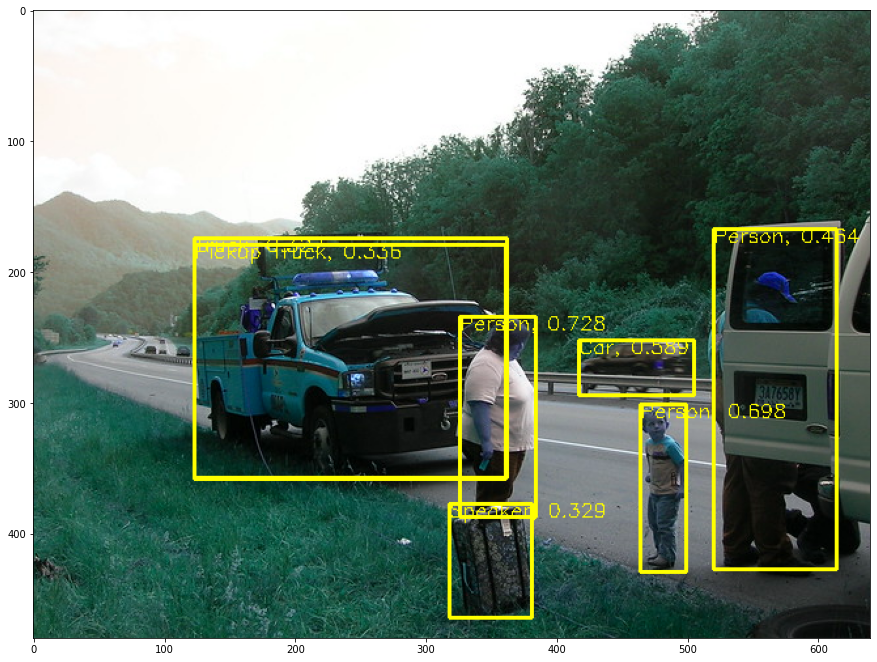

In [ ]:
!wget http://farm4.staticflickr.com/3019/3859204547_1f63f18894_z.jpg -O ./test.jpg
img = cv2.imread('test.jpg')
threshold = 0.325
iou_threshold = 0.01
processed_immage = detectObjects(img)
plt.figure(figsize = (15,15))
plt.imshow(processed_immage)
plt.show()

We can also perform predictions on videos and track objects in a video
Let's start by downloading a video from YouTube

In [ ]:
from pytube import YouTube
video_url = "https://youtu.be/pO6wDBss8PI"
video = YouTube(video_url)
video_src = video.streams.get_by_itag(137).download()

We use  openCV to open the video and extract each frame. We then perform predictions on each frame and write the process frame with the banding boxes to a new video file.

In [ ]:
# Video capture
cap = cv2.VideoCapture(video_src)
# VideoWriter
res=(1920,1080) #resulotion
fourcc = cv2.VideoWriter_fourcc(*'MP4V') #codec
out_write = cv2.VideoWriter('video2.mp4', fourcc, 20.0, res)
process_timer = time.time()
while True:
    ret, frame = cap.read()
    if not ret:
        break

    img_show = detectObjects(frame)

    # show frame by frame
    out_write.write(img_show)
    processing_time = "{:.2f}".format(time.time() - process_timer)
    print(f"Processed Frame in {processing_time} seconds")
    process_timer = time.time()


cap.release()
out_write.release()

In [ ]:
from moviepy.editor import *
clip = (VideoFileClip("video2.mp4"))
clip_resized =  clip.resize(height=360) 
path =  clip_resized.write_videofile("movie_resized.mp4", bitrate="500k")

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)1302528/45929032 bytes (2.8%)3457024/45929032 bytes (7.5%)6291456/45929032 bytes (13.7%)9273344/45929032 bytes (20.2%)12607488/45929032 bytes (27.4%)15925248/45929032 bytes (34.7%)19210240/45929032 bytes (41.8%)22446080/45929032 bytes (48.9%)25845760/45929032 bytes (56.3%)29229056/45929032 bytes (63.6%)32448512/45929032 bytes (70.6%)35782656/45929032 bytes (77.9%)391

100%|█████████▉| 1248/1249 [00:44<00:00, 28.11it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: movie_resized.mp4 



# finally let's look at the result!

In [ ]:
from IPython.display import HTML
from base64 import b64encode

def play(filename):
    html = ''
    video = open(filename,'rb').read()
    src = 'data:video/mp4;base64,' + b64encode(video).decode()
    html += '<video width=1000 controls autoplay loop><source src="%s" type="video/mp4"></video>' % src 
    return HTML(html)

play('movie_resized.mp4')

# Let's review what we have learned

Let’s recap what we have learned so far. We have learned how to build a custom dataset logo and make it robust against corrupted files and missing labels; we then learned how to create custom batches for training in the PyTorch model. 
We also learned how to connect an external network storage drive such as Google cloud storage. And train a model on the data hosted without downloading the entire data said this is great for not only security but also practicality .as you do not need to waste time downloading large data sets. We then demonstrated how the model could be used to perform predictions on both images and videos.
